In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import color_detection
import warp_points_detection
import hough
import utils


In [2]:
# Read images

img = cv.imread('test2.jpg', 1)
img = cv.resize(img, (512, 512))

mask = np.zeros([512,512,3],np.uint8)

print(img.shape)
print(img.size)
print(img.dtype)

(512, 512, 3)
786432
uint8


In [ ]:
img = cv.imread('test2.jpg',0)
# Thresholding
_, th1 = cv.threshold(img, 200, 255, cv.THRESH_BINARY)
_, th2 = cv.threshold(img, 100, 150, cv.THRESH_BINARY_INV)
_, th3 = cv.threshold(img, 200, 255, cv.THRESH_TRUNC)
_, th4 = cv.threshold(img, 200, 255, cv.THRESH_TOZERO)
_, th5 = cv.threshold(img, 200, 255, cv.THRESH_TOZERO_INV)
th6 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 101, 2)
th7 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 101, 2)

titles = ['original', 'BINARY', 'BINARY INV', 'TRUNC', 'TO ZERO', 'TO ZERO INV', 'ADAPTIVE MEAN', 'ADAPTIVE GAUSSIAN']
images = [img, th1, th2, th3, th4, th5, th6, th7]

for i in range(len(images)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

plt.show()

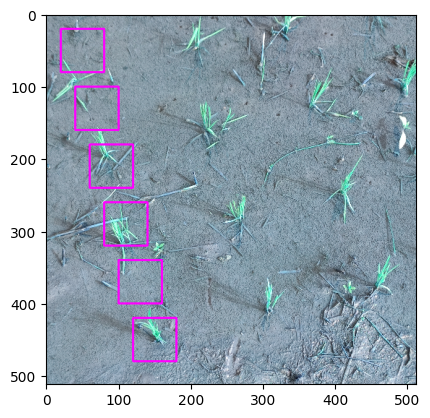

In [3]:
# Create bounding boxes
coordinates = np.array([
    [[20, 20], [80, 80]],
    [[40, 100], [100, 160]],
    [[60, 180], [120, 240]],
    [[80, 260], [140, 320]],
    [[100, 340], [160, 400]],
    [[120, 420], [180, 480]]
])

for c1, c2 in coordinates:
    img_rect = cv.rectangle(img, c1, c2, (255, 0, 255), 2)
plt.imshow(img_rect)
plt.show()

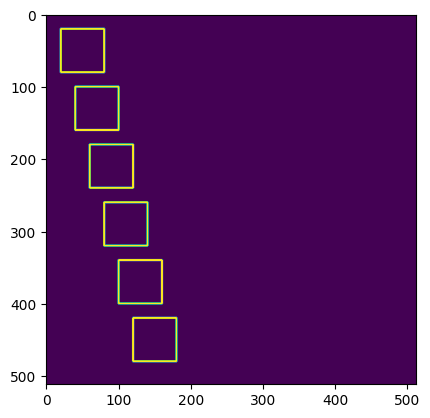

In [4]:
# Thresholding to separate bounding boxes with backgrounds
# color_detection.detect_color_img(img_rect)
img_thresh = utils.thresholding(img_rect, 150, 150, 255, 255, 255, 255)
plt.imshow(img_thresh)
plt.show()
# Note
#   h = (150, 150)
#   s = (255, 255)
#   v = (255, 255)

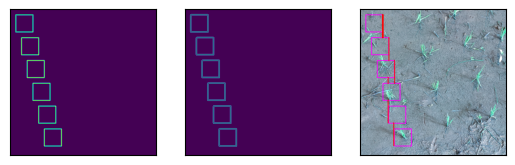

In [9]:
# Hough Transform
# img_hough = hough.hough_tf(img_rect, show=True)
img_lane = img.copy()
edges = cv.Canny(img_thresh, 150, 255, apertureSize=3)
lines = cv.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=20, maxLineGap=40)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv.line(img_lane, (x1, y1), (x2, y2), (255, 0, 0), 2)
images = [img_thresh, edges, img_lane]
for i in range(len(images)):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
# Linearization
img_linear = img_rect
for c1, c2 in coordinates:
    x1, y1 = c1
    x2, y2 = c2
    cv.line(img_linear, (x1, y1), (x2, y2), (255, 0, 255), 1)
plt.imshow(img_linear)
plt.show()